In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)

[nltk_data] Downloading package brown to
[nltk_data]     /Users/daimyvanloo/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

In [2]:
class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        self.data = None
        self.word_to_idx = None # Convert the unique words to an index dictionary {word: index}
        self.targets = None # Make these indexes the target values
        
        corpus = nltk.corpus.brown.words()

        # use a set to only keep unique words
        self.data = list(set(corpus))[:5000] 
        self.data = [word.lower() for word in self.data]
        
        self.word_to_idx = {word: index for index, word in enumerate(self.data)}
        self.targets = [self.word_to_idx[word] for word in self.data]

    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.
        
        word = x
        x = [0] * 26

        for letter in word:
            # since x has 26 slots, only for letters a-z we check the letter is actually in the alphabet (not a number or punctuation for example)
            if letter.isalpha(): 

                # I found this function that returns the integer representing a unicode character
                # for ord('a'), this is 97, so we need to subtract this from ord(letter) to get the actual index in the alphabet
                # https://docs.python.org/3.4/library/functions.html#ord
                x[ord(letter) - ord('a')] += 1
                
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        
        return x, y
    

Below is a test cell to understand how the ord() function works and if the output is consistent with the example given in the comment.

In [3]:
def numeric_vector(word):
    """
    Convert a word to a numeric vector of 26 numbers, counting the occurrences of the letters.
    This function is used to test whether the implementation is correct.
    """
    word = word.lower()
    x = [0] * 26

    for letter in word:
        if letter.isalpha():
            print(f"Unicode integer for {letter}: {ord(letter)}")
            print(f"Unicode integer for 'a': {ord('a')}")
            print(f"Index in alphabet for {letter}: {ord(letter) - ord('a')}")

            x[ord(letter) - ord('a')] += 1
            
    x = torch.tensor(x, dtype=torch.float32)

    return x

# Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.
print(numeric_vector('Apple'))

Unicode integer for a: 97
Unicode integer for 'a': 97
Index in alphabet for a: 0
Unicode integer for p: 112
Unicode integer for 'a': 97
Index in alphabet for p: 15
Unicode integer for p: 112
Unicode integer for 'a': 97
Index in alphabet for p: 15
Unicode integer for l: 108
Unicode integer for 'a': 97
Index in alphabet for l: 11
Unicode integer for e: 101
Unicode integer for 'a': 97
Index in alphabet for e: 4
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 2., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()
        # Implement the neural network layers, the activation function is already defined
        self.input_layer = nn.Linear(input_size, hidden_size[0])
        self.hidden_layer = nn.Linear(hidden_size[0], hidden_size[1])
        self.output_layer = nn.Linear(hidden_size[1], output_size)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # In the forward pass the model will calculate the gradients as well as the probabilities of the result occuring given its input.
        # Implement the missing layers

        x = self.input_layer(x) # Implement input layer
        x = self.activation(x)
        x = self.hidden_layer(x) # Implement hidden layer
        x = self.activation(x)
        x = self.output_layer(x) # Implement the output layer

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [5]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'cpu' # If you have an m1 macbook use: 'mbp', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [6]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [7]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

/Users/daimyvanloo/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [9]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        # print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

Training_loss: 7.964288711547852
Validation_loss: 1.1954620909690856
Training_loss: 7.726710796356201
Validation_loss: 1.2536211657524108
Training_loss: 7.46925687789917
Validation_loss: 1.3151252746582032
Training_loss: 7.681225776672363
Validation_loss: 1.377433180809021
Training_loss: 7.528163909912109
Validation_loss: 1.439780707359314
Training_loss: 7.734356880187988
Validation_loss: 1.5026351666450501
Training_loss: 7.306392669677734
Validation_loss: 1.5667619109153748
Training_loss: 7.1134467124938965
Validation_loss: 1.633187005519867
Training_loss: 7.078724384307861
Validation_loss: 1.7020516872406006
Training_loss: 7.125450134277344
Validation_loss: 1.7743808364868163
Training_loss: 5.9545135498046875
Validation_loss: 1.8501703810691834
Training_loss: 6.416904926300049
Validation_loss: 1.930036334991455
Training_loss: 6.591945171356201
Validation_loss: 2.014540934562683
Training_loss: 6.518001556396484
Validation_loss: 2.1040125584602354
Training_loss: 6.336894989013672
Valid

### Writing
**Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?**

If the validation loss increases, this means there is overfit on the training data in the model. This means that the model is modelling the training data too closely, where it is not just picking up general patterns that will generalize to other data well, but it is also picking up on the specific patterns unique to the training data. 

For our specific case, this probably means that the model is learning to predict words that are in the training data, since this is the only data it can learn from. But for the validation data, this means that the model incorrectly predicts words, since the training words are not in the validation data.

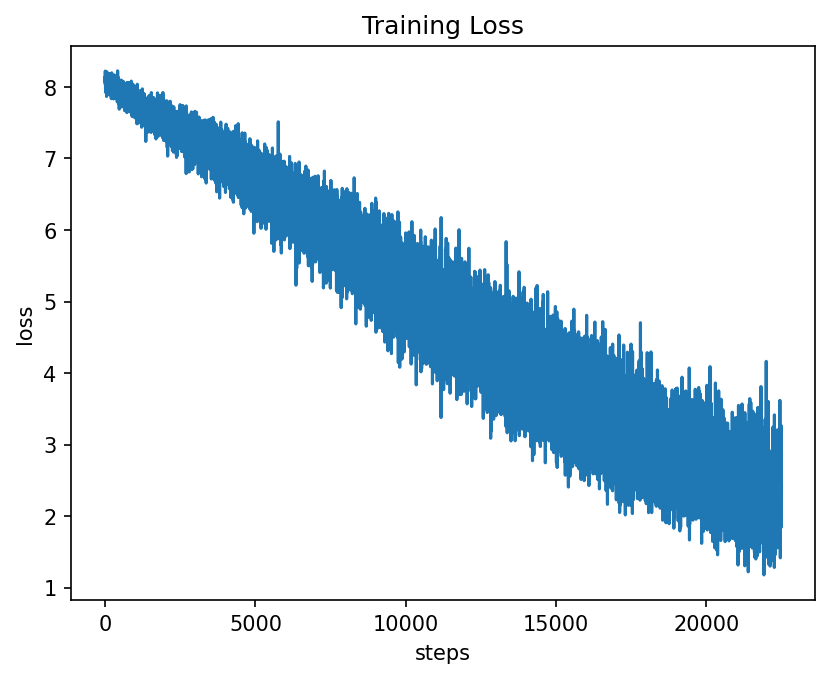

In [11]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

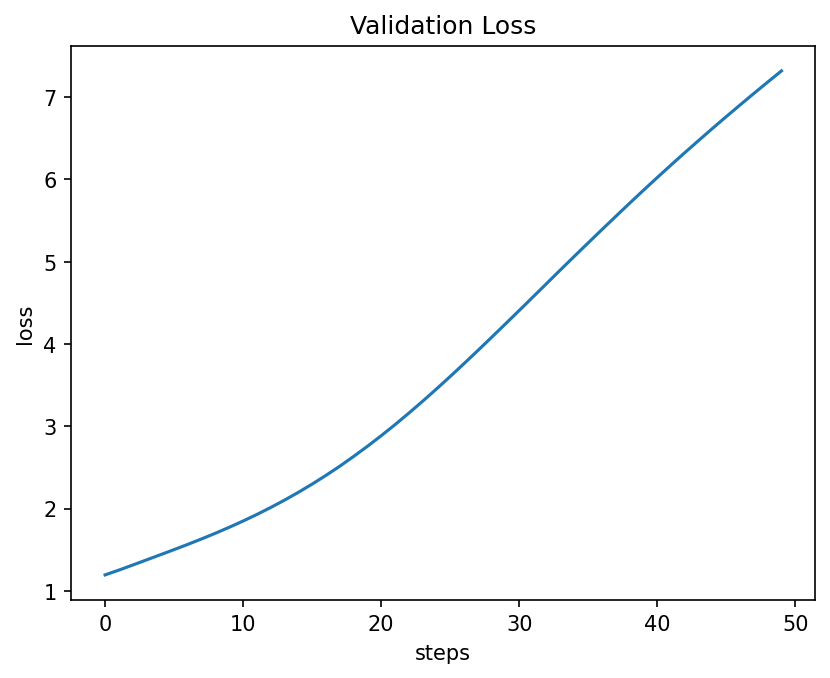

In [12]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
**Below we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?**

Looking at the first 10 words predicted by our model from the test data, a couple of observations can be made:
1. **All words are predicted incorrectly**. This can probably be attributed to the observations made in the question above; the model is overfitting on the training data. It has only ever seen the training words get correctly predicted, so it has learned to predict these words to be correct.

2. **The target and predicted words are similar in letters**. When you look at targets en predictions like 'earmarked' and 'Kader', 'Orwell' and 'lower', or 'shift' and 'fish', it is clear that there is significant overlap in the letters between these words. *Note: these are previous words that were shown when printing the targets and predictions, after running again the words have changed, but the same principle still holds.* This indicates that the model *has* in fact learned something that we were trying to achieve; it is able to map a numerical vector representation to the corresponding letters. 
However, since this representation does not include any positional information, the model could never learn the position of these letters in the words. Thus, it is not learning the actual words, or word meanings, but just letter overlap.

3. **All predicted words are from the training data**. This again goes back to the overfitting problem; the model has only ever learned that the training words result in a correct prediction, and since there is not overlap between training and testing words, it is just predicting the training words that are similar in letters to the testing words.

In [13]:
def get_n_words(dataset, n, model, ds, verbose = True):
    if n == -1:
        n = len(dataset)
    x = [dataset.__getitem__(i)[0] for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    target_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in y]
    out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]
    predicted_words = [{idx: word for word, idx in ds.word_to_idx.items()}[_.item()] for _ in out]

    # add word vectors to ouptput so I can use it later for similarities
    target_vectors = [ds.__getitem__(ds.word_to_idx[_])[0] for _ in target_words]
    pred_vectors = [ds.__getitem__(ds.word_to_idx[_])[0] for _ in predicted_words]


    width = max(len(word) for word in target_words) + 5
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    return target_words, predicted_words, target_vectors, pred_vectors

targets, preds, target_vectors, pred_vectors = get_n_words(test_dataset, 10, model, dataset)

target: 1,450,000         predicted: 1881
target: veining           predicted: begin
target: prophet           predicted: hopper
target: gray              predicted: gay
target: flocculation      predicted: falcon
target: froze             predicted: offer
target: wither            predicted: whitehaired
target: something         predicted: westinghouse
target: eluard            predicted: hurled
target: previous          predicted: supervisory


/var/folders/bz/c9qp5jf94x376hszbngq55c40000gn/T/ipykernel_4642/3001943980.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


The following cell is used to show that predicted words are only from the train set, and do not occur in the test set.

In [14]:
test_words = [{idx: word for word, idx in dataset.word_to_idx.items()}[_.item()] for _ in [test_dataset.__getitem__(i)[1] for i in range(len(test_dataset))]]
train_words = [{idx: word for word, idx in dataset.word_to_idx.items()}[_.item()] for _ in [train_dataset.__getitem__(i)[1] for i in range(len(train_dataset))]]

for word in preds:
    if word in test_words:
        print(f"The predicted word '{word}' is in the test set.")
    if word in train_words:
        print(f"The predicted word '{word}' is in the train set.")

The predicted word '1881' is in the train set.
The predicted word 'begin' is in the train set.
The predicted word 'hopper' is in the train set.
The predicted word 'gay' is in the train set.
The predicted word 'falcon' is in the train set.
The predicted word 'offer' is in the train set.
The predicted word 'whitehaired' is in the train set.
The predicted word 'westinghouse' is in the train set.
The predicted word 'hurled' is in the train set.
The predicted word 'supervisory' is in the train set.


**Why are some words incorrectly predicted?**

As mentioned in previous questions, the model is clearly overfitting on the training data. In short, the model is learning to predict the words that are in the training data. Since the words in the validation data and test data are by definition different (we chose 5000 unique words), the model never learns to predict these words.

Illustrating this:

The model has 5000 outputs; 1 for every unique word we extracted from the corpus. Let's say the training data contains 3600 of these unique words. During training, the model gets different numerical vectors as input and learns which inputs map to which output node. Since we only have 3600 out of 5000 words in the training data, the model never receives any input that leads to any of the other 1400 output nodes to be correct. The model also has no 'idea' what these output nodes represent, it just learns that certain inputs map to certain outputs. It can thus never learn that the number of letters in the input has to match the number of letters in the output; it has no 'idea' which letters are in the output.

### Code + Written
**Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.**

The following article was used to research the Jaccard metric: https://mayurdhvajsinhjadeja.medium.com/jaccard-similarity-34e2c15fb524.

The Jaccard similarity metric is usually used to get a similarity score for pieces of text, looking at the word overlap between all unique words of each text. If you have two pieces of text with exactly the same words (e.g. "The chef chops the onion" and "The onion chops the chef"), the Jaccard metric wil give a score of 1. The given example already shows what could happen here; two pieces of text may have the exact same words, a different meaning, and a similarity score of 1. The formula for the Jaccard metric is as follows:

Jaccard Similarity = (number of overlapping unqiue words) / (total unique number of words)

I decided to compare the Jaccard metric to the Cosine similarity metric we saw in the previous assignment. In order to do this, I use the word vectors of size 26 we created before. We can use these vectors has they actually give some information on how similar words are, as a higher number on a certain index means the same for one word as any other. In this way they are more similar to word embeddings we saw in the previous assignment, as opposed to a sparse vector of vocabulary size we saw.

Below are the implementations of the metrics, and the printed similarity scores for each. The metrics are compared below the implementations.

### Jaccard Similarity

In [ ]:
def jaccard_similarity(targets, predictions):
    # make sure each prediction has a target
    if len(targets) != len(predictions):
        raise ValueError("The lengths of the two lists must be equal.")
    
    similarities = []

    # calculate the Jaccard similarity for each pair of target and prediction
    for i in range(len(targets)):
        target_set = set(targets[i])
        prediction_set = set(predictions[i])

        similarities.append(len(target_set & prediction_set) / len(target_set | prediction_set))

    return similarities


In [ ]:
targets, preds, _, _ = get_n_words(test_dataset, -1, model, dataset, verbose=False)
similarities = jaccard_similarity(targets, preds)

# for nice print formatting
width = max(len(word) for word in targets) + 2

print('\n'.join([f'target: {t.ljust(width)} predicted: {p.ljust(width)} similarity: {s}' for t, p, s in zip(targets, preds, similarities)]))

/var/folders/bz/c9qp5jf94x376hszbngq55c40000gn/T/ipykernel_4642/3001943980.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


target: 1,450,000                     predicted: 1881                          similarity: 0.16666666666666666
target: veining                       predicted: begin                         similarity: 0.6666666666666666
target: prophet                       predicted: hopper                        similarity: 0.8333333333333334
target: gray                          predicted: gay                           similarity: 0.75
target: flocculation                  predicted: falcon                        similarity: 0.6666666666666666
target: froze                         predicted: offer                         similarity: 0.8
target: wither                        predicted: whitehaired                   similarity: 0.75
target: something                     predicted: westinghouse                  similarity: 0.7272727272727273
target: eluard                        predicted: hurled                        similarity: 0.7142857142857143
target: previous                      predicted: sup

### Cosine Similarity

In [ ]:
import numpy as np

def cosine_similarity(target_vectors, pred_vectors):
    # make sure each prediction has a target
    if len(target_vectors) != len(pred_vectors):
        raise ValueError("The lengths of the two lists must be equal.")
    
    similarities = []

    # calculate the cosine similarity for each pair of target and prediction vectors
    for i in range(len(target_vectors)):
        similarities.append(np.dot(target_vectors[i], pred_vectors[i]) / (np.linalg.norm(target_vectors[i]) * np.linalg.norm(pred_vectors[i])))

    return similarities

In [ ]:
targets, preds, target_vectors, pred_vectors = get_n_words(test_dataset, -1, model, dataset, verbose=False)
similarities = cosine_similarity(target_vectors, pred_vectors)

# for nice print formatting
width = max(len(word) for word in targets) + 2

print('\n'.join([f'target: {t.ljust(width)} predicted: {p.ljust(width)} similarity: {s}' for t, p, s in zip(targets, preds, similarities)]))

/var/folders/bz/c9qp5jf94x376hszbngq55c40000gn/T/ipykernel_4642/3001943980.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = [nn.functional.softmax(model(wrd)).argmax() for wrd in x]


target: 1,450,000                     predicted: 1881                          similarity: nan
target: veining                       predicted: begin                         similarity: 0.809039831161499
target: prophet                       predicted: hopper                        similarity: 0.9428091049194336
target: gray                          predicted: gay                           similarity: 0.866025447845459
target: flocculation                  predicted: falcon                        similarity: 0.866025447845459
target: froze                         predicted: offer                         similarity: 0.8451542854309082
target: wither                        predicted: whitehaired                   similarity: 0.8911327719688416
target: something                     predicted: westinghouse                  similarity: 0.8333333134651184
target: eluard                        predicted: hurled                        similarity: 0.8333332538604736
target: previous            

/var/folders/bz/c9qp5jf94x376hszbngq55c40000gn/T/ipykernel_4642/1845527640.py:10: RuntimeWarning: invalid value encountered in scalar divide
  similarities.append(np.dot(target_vectors[i], pred_vectors[i]) / (np.linalg.norm(target_vectors[i]) * np.linalg.norm(pred_vectors[i])))


### Comparison

There are a few observations that stand out from the similarity values for each metric:

1. Jaccard similarity is able to deal with numbers, while cosine similarity is not. This is not surprising, as Jaccard simply takes the set of characters in each words, while the Cosine method takes the word vectors. As the word vectors we created only have space for 26 entries (all alphabetical characters), numbers and other characters are by definition excluded. The cosine metric will therefore sometimes output NaN. This could be fixed by adding additional entries to the vectors, for more characters.

2. Both metrics can not work with positional information. This is apparent from words that have exactly the same amount and the same characters, but are completely different. For example, the words 'madison' and 'domains' receive a similarity score of 1 for both metrics, because their character overlap is identicaly, but the characters are in completely different orders.

3. In my opinion, the cosine similarity is too biased toward very positive values. As you scroll through all cosine similarity values, most values are above .8, and almost no values are below .6. For example, the words 'front-line' and 'inconveniently' get a .83 cosine similarity score, but only .5 with Jaccard. It seems that the cosine similarity score puts a lot of emphasis on characters that **do** overlap, but not on characters that are different. Jaccard explicitly takes into account the total number of unique characters as the denumerator, so if there are many letters that do not appear in both words, this score decreases. 

Given these observations, I would say that the Jaccard similarity score would be preferred here. First, it is able to deal with all characters, not just alphabetic letters. Second, it seems more accurate in it's similarity score, also taking into account missing characters in either word.